In [1]:
import torch

In [2]:
GPU_NUM = 0
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')

Current cuda device  1
GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:
from load_data import *

In [4]:
Xtr, Xte, ytr, yte, Ztr, Zte = load_german_data()
ytr = ytr.astype('float32').reshape((-1,1))
yte = yte.astype('float32').reshape((-1,1))

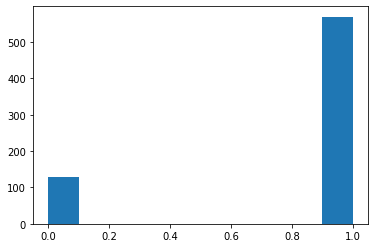

In [5]:
import matplotlib.pyplot as plt
plt.hist(Ztr[:,0])
plt.show()

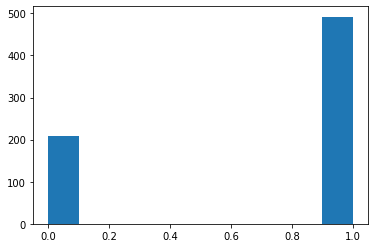

In [6]:
plt.hist(ytr)
plt.show()

In [7]:
sum(Ztr==0)/len(Ztr)

array([0.18571429])

In [8]:
print('# training samples:', Xtr.shape)
print('# test samples:', Xte.shape)
print('# sensitive vars', Ztr.shape)


# training samples: (700, 23)
# test samples: (300, 23)
# sensitive vars (700, 1)


In [9]:
N1 = 100
Xtr1 = Xtr[:N1]
ytr1 = ytr[:N1]
Ztr1 = Ztr[:N1]
Xtr2 = Xtr[N1:]
ytr2 = ytr[N1:]
Ztr2 = Ztr[N1:]

In [10]:
Ztr.shape

(700, 1)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [12]:
from fairNN_train import *
from load_data import *

In [13]:
n_features = Xtr.shape[1]
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

In [14]:
class Args:
    def __init__(self):
        self.epochs = 30
        self.AL_iters = 10
        self.AL_batch = 32
        self.batch_size = 32
        self.AL_select = 'loss'
        
    def print_args(self):
        print("train epochs/batch: {}/{}".format(self.epochs,self.batch_size))
        print("AL iters/batch: {}/{}".format(self.AL_iters,self.AL_batch))
        print("AL selection is based on ", self.AL_select)

In [15]:
args = Args()

In [16]:
train_data = NPsDataSet(Xtr1, ytr1, Ztr1)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, drop_last=True)

In [17]:
train_loader.dataset.tensors[-1].shape

torch.Size([100, 1])

In [18]:
from fair_eval import *

In [19]:
zZtr2 = transform_dum2cat(Ztr2)
select_data = NPsDataSet(Xtr2, ytr2, zZtr2)
select_loader = DataLoader(select_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

In [20]:
test_data = NPsDataSet(Xte, yte, Zte)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, drop_last=False)

- gradient calculation for unlabeled set
- expectation 
- https://discuss.pytorch.org/t/how-to-efficiently-compute-gradient-for-each-training-sample/60001/2 
- https://github.com/cybertronai/autograd-hacks#per-example-gradients 
- https://tutorials.pytorch.kr/intermediate/tensorboard_tutorial.html

In [21]:
n_features = Xtr.shape[1]
clf = Classifier(n_features=n_features).cuda()
criterion = nn.BCELoss()
optimizer = optim.Adam(clf.parameters())

In [22]:
clf.eval()
preds = clf(torch.tensor(Xtr[:10],dtype = torch.float32).cuda())

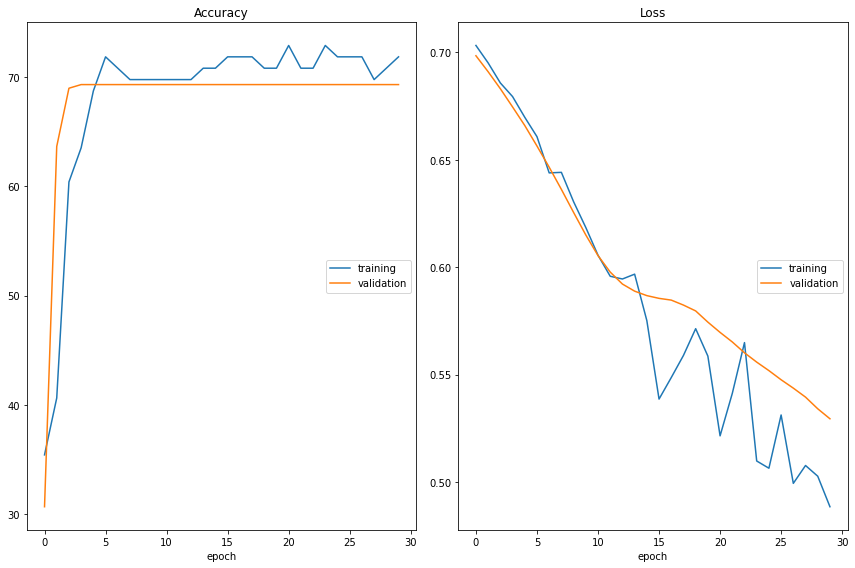

Accuracy
	training         	 (min:   35.417, max:   72.917, cur:   71.875)
	validation       	 (min:   30.667, max:   69.333, cur:   69.333)
Loss
	training         	 (min:    0.488, max:    0.703, cur:    0.488)
	validation       	 (min:    0.529, max:    0.698, cur:    0.529)
Finished Training


In [21]:
train_model(clf, train_loader, criterion, optimizer, device, args, test_loader)

In [22]:
dldic = divide_groupsDL(Xtr1,ytr1,Ztr1)

[0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1.]


In [108]:
dldic

{0.0: <torch.utils.data.dataloader.DataLoader at 0x7f69fc94ddf0>,
 1.0: <torch.utils.data.dataloader.DataLoader at 0x7f69fd3eb670>}

In [23]:
trTensors = train_loader.dataset.tensors
dldic = divide_groupsDL(trTensors[0],trTensors[1],trTensors[2])

[0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 1.]


/home/srp/Fairness/fairness_AL/codes/load_data.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensors = (torch.tensor(da).float() for da in dataarrays)


In [217]:
print(type(Xtr)==np.ndarray)

True


In [219]:
type(trTensors[2]) == torch.Tensor

True

# Group Selection Part

## Test Group Performance

In [25]:
from fair_eval import *

In [110]:
def test_model_noz(model, test_loader, criterion, device):
    model.eval()
    losses = AverageVarMeter()
    accs = AverageVarMeter()
    for batch_idx, (x,y) in enumerate(test_loader):
        x = x.to(device)
        y = y.to(device)
        p_y = model(x)
        loss = criterion(p_y,y)
        
        acc = accuracy_b(p_y, y.detach().cpu())
        losses.update(loss,x.size(0))
        accs.update(acc,x.size(0))
    return losses.avg, accs.avg

In [111]:
for did in dldic.keys():
    print(did, ":", test_model_noz(clf, dldic[did],criterion, device))

0.0 : (tensor(0.5414, device='cuda:1', grad_fn=<DivBackward0>), tensor(66.6667))
1.0 : (tensor(0.4916, device='cuda:1', grad_fn=<DivBackward0>), tensor(72.3684))


## find examples for the worst group

In [24]:
from fairAL_utils import *

In [113]:
grads = group_grad(clf,dldic, criterion,device)

0.0
1.0


In [114]:
torch.matmul(grads[0.0],grads[1.0])

tensor(0.7189, device='cuda:1')

In [116]:
aa = torch.topk(compute_gradsim(clf, select_loader, criterion, grads[0.0], device),32)

In [117]:
print(aa)

torch.return_types.topk(
values=tensor([0.5606, 0.5110, 0.4959, 0.4957, 0.4945, 0.4930, 0.4918, 0.4627, 0.4565,
        0.4475, 0.4469, 0.4321, 0.4267, 0.4174, 0.4127, 0.4110, 0.4089, 0.4012,
        0.3997, 0.3913, 0.3907, 0.3836, 0.3823, 0.3799, 0.3797, 0.3758, 0.3681,
        0.3664, 0.3655, 0.3638, 0.3578, 0.3567], device='cuda:1'),
indices=tensor([498, 100, 494, 439, 355, 379,   9, 152, 188, 251, 219, 317, 255, 396,
        112, 544, 474, 412, 246, 294, 457, 105,  45, 232, 409, 382, 424, 539,
         65,  40, 358, 411], device='cuda:1'))


In [118]:
select_loader.dataset.tensors[2][aa[1]]

tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1.])

In [43]:
def select_examples(clf,select_loader,criterion, grad_z, device, nsample = 32):
    aa = torch.topk(compute_gradsim(clf, select_loader, criterion, grad_z, device),nsample)
    ses = []
    for ts in select_loader.dataset.tensors:
        ses.append(ts[aa[1]])
    return ses,aa[1]

In [128]:
ses,sidx = select_examples(clf, select_loader, criterion, grads[0.0],device, nsample = 32)

In [147]:
ses[2] = ses[2].reshape(-1,1)

## retraining models

In [44]:
def obtain_newDS(train_loader, select_loader,ses, sidx, batch_size = 32):
    ds1 = []
    for i, tss in enumerate(train_loader.dataset.tensors):
        ds1.append(np.append(tss,ses[i],axis = 0))
    ds2 = []
    for tss in select_loader.dataset.tensors:
        ds2.append(np.delete(tss,sidx.detach().cpu(),axis=0))
    tr_loader = DataLoader(NPsDataSet(ds1[0],ds1[1],ds1[2]),batch_size = batch_size, shuffle=True)
    se_loader = DataLoader(NPsDataSet(ds2[0],ds2[1],ds2[2]),batch_size = batch_size, shuffle=False)
    
    return tr_loader, se_loader

In [163]:
train_loader2, select_loader2 = obtain_newDS(train_loader, select_loader, ses, sidx, 32)

In [ ]:
train_loader.dataset.tensors

In [24]:
torch.argmax(torch.tensor([1,2,3]))

tensor(2)

In [165]:
train_loader2.dataset.tensors[0].shape

torch.Size([164, 23])

In [189]:
args.print_args()

train epochs/batch: 30/32
AL iters/batch: 10/32


In [29]:
def group_grad(clf, dldic, criterion, device):
    grads={}
    clf.eval()
    for did in dldic.keys():
        print(did)
        grads[did] = cal_meangrad(clf, dldic[did], criterion, device)
    return grads
def cal_meangrad(clf, dataloader, criterion, device):
    
    for i,(x,y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)
        clf.zero_grad()
        outs = clf(x)
        criterion(outs,y).backward()
        tmp = []
        for param in clf.parameters():
            tmp.append(param.grad.flatten())
        grads_t = torch.cat(tmp)
        if i==0:
            grads = grads_t
        else:
            grads += grads_t
    prgrad_n = torch.norm(grads)
    grads /= prgrad_n
    grads = grads.detach().cpu()
    return grads

In [60]:
def compute_gradsim(clf, select_loader, criterion, grad_z,device):
    clf.eval()
    autograd_hacks.add_hooks(clf)
    sims = []
    for i, (x,y,_) in enumerate(select_loader):
        x = x.to(device)
        y = y.to(device)
        clf.zero_grad()
        clear_backprops(clf)
        outs = clf(x)
        count_backprops(clf)
        criterion(outs,y).backward()
        remove_backprops(clf)
        autograd_hacks.compute_grad1(clf)
        tmp = []
        for j, param in enumerate(clf.parameters()):
            tmp.append(param.grad1.reshape(x.size(0),-1))
        grad_t = torch.cat(tmp,dim=1).cuda()
        print(grad_t)
        print(grad_z)
        sims.append(torch.matmul(grad_t,grad_z.cuda()))
    return torch.cat(sims).detach().cpu()

In [26]:
def train_AL(train_loader, select_loader, device, args = None, test_loader = None, from_scratch = False):
    if args is None:
        args = Args()
    print("arguments: ", args.print_args())
    n_features = train_loader.dataset.tensors[0].shape[1]
    if from_scratch == False:
        clf = Classifier(n_features=n_features)
        clf_criterion = nn.BCELoss()
        clf_optimizer = optim.Adam(clf.parameters())
    
    assert((args.AL_iters-1)*args.AL_batch<select_loader.dataset.tensors[0].shape[0])
    for it in range(args.AL_iters):
        if from_scratch:
            clf = Classifier(n_features=n_features)
            clf_criterion = nn.BCELoss()
            clf_optimizer = optim.Adam(clf.parameters())
        clf.cuda()
        train_model(clf, train_loader, clf_criterion, clf_optimizer, device, args, test_loader)
        trTensors = train_loader.dataset.tensors
        dldic = divide_groupsDL(trTensors[0],trTensors[1],trTensors[2])
        losss = 0
        accs = 0
        sid = list(dldic.keys())[0]
        for did in dldic.keys():
            loss_v, acc_v = test_model_noz(clf, dldic[did],clf_criterion, device)
            print("{} : loss {} / acc {}".format(did, loss_v, acc_v))
            if args.AL_select == 'loss':
                if losss > loss_v:
                    sid = did
            else:
                assert args.AL_select == 'acc'
                if accs < acc_v:
                    sid = did
        if it <args.AL_iters-1:
            grads = cal_meangrad(clf, dldic[sid], clf_criterion, device)
            ses,sidx = select_examples(clf, select_loader, clf_criterion, grads,device, args.AL_batch)
            print(ses)
            train_loader, select_loader = obtain_newDS(train_loader, select_loader, ses, sidx, args.batch_size)
    return clf    

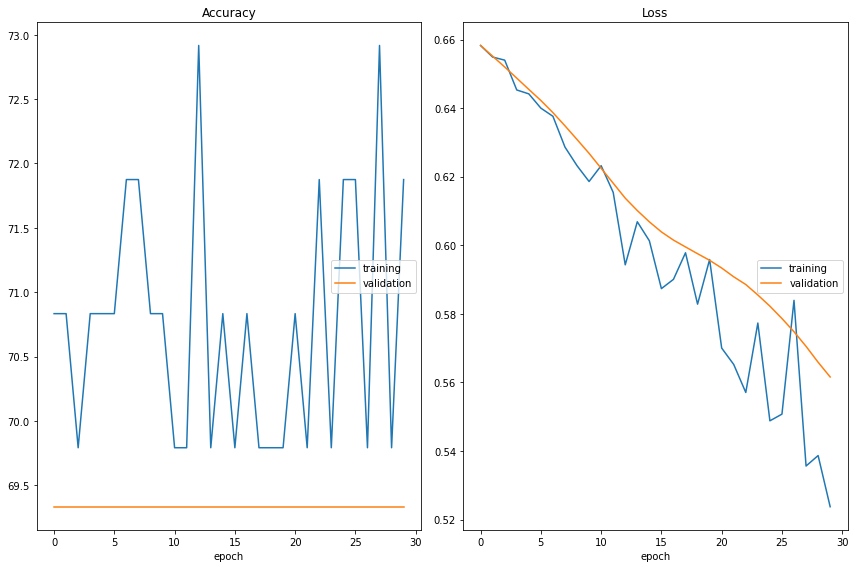

Accuracy
	training         	 (min:   69.792, max:   72.917, cur:   71.875)
	validation       	 (min:   69.333, max:   69.333, cur:   69.333)
Loss
	training         	 (min:    0.524, max:    0.658, cur:    0.524)
	validation       	 (min:    0.562, max:    0.658, cur:    0.562)
Finished Training


IndexError: The shape of the mask [100, 1] at index 1 does not match the shape of the indexed tensor [100, 23] at index 1

In [27]:
train_AL(train_loader, select_loader, device, args, test_loader, from_scratch = False)

[0.0, 1.0]